# 🎧 Pipeline Audio Minimal – Validation Empirique

Dans ce notebook, nous allons analyser un fichier audio de 10 secondes en :

- Découpant le signal en 2 segments de 5 secondes
- Travaillant avec 3 fichiers audio : original 10s + 2 segments 5s
- Comparant les différentes features : MFCC, Log-Mel, Wav2Vec2

---

## 📦 Bloc 0 – Imports, configuration et chemin du projet

Dans cette première section, nous :

- Importons toutes les bibliothèques nécessaires
- Configurons dynamiquement les chemins via le fichier `config.py`
- Définissons le chemin du fichier `.wav` de 10 secondes à analyser
- Créons le dossier `data/segments` pour sauvegarder les fichiers extraits

Le fichier source sera ensuite découpé en deux segments de 5s.


In [1]:
# 📌 Importation des bibliothèques essentielles
import os
import sys
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
from pathlib import Path
import librosa.display
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# 📌 Configuration globale
import warnings
warnings.filterwarnings('ignore')

# 📂 Ajout dynamique du répertoire principal au PYTHONPATH
project_root = Path.cwd().parent  # DCASE2024_ASD_Project/
sys.path.append(str(project_root))

# 📂 Importation des modules du projet
from src import config, processing, visualization
from src.utils.logger_utils import configure_logger

# 🔧 Configuration du logger
logger = configure_logger()
logger.info("🎧 Pipeline Audio Minimal – Validation Empirique")

# 🎛️ Configuration globale
sr = config.SR  # Taux d'échantillonnage
segment_duration = 5  # Durée d'un segment en secondes
segment_samples = sr * segment_duration  # Nombre d'échantillons par segment

# 🔊 Test sur un fichier audio
input_path = config.ROOT_PROJECT_DIR / "data/sample_10s.wav"  # Fichier audio source (10 secondes)

# 📁 Dossier pour sauvegarder les segments découpés
output_dir  = config.ROOT_PROJECT_DIR / "data/processed_audio"
output_dir.mkdir(parents=True, exist_ok=True)


2025-03-24 11:43:43 - INFO - 🎧 Pipeline Audio Minimal – Validation Empirique


## ✂️ Bloc 1 – Découpage du fichier audio 10s en deux segments 5s

Ce bloc lit le fichier source `sample_10s.wav`, puis :

- Vérifie que le fichier fait bien au moins 10 secondes
- Découpe le signal en deux parties :
  - Segment 1 : de 0 à 5 secondes
  - Segment 2 : de 5 à 10 secondes
- Sauvegarde chaque segment dans le dossier `data/processed_audio/` au format `.wav`


In [2]:
# 🎧 Chargement du fichier audio
y, _ = librosa.load(input_path, sr=sr)

# 🕒 Vérification durée
duration_sec = len(y) / sr
logger.info(f"Durée du fichier audio : {duration_sec:.2f} sec")

if duration_sec < 10:
    raise ValueError("Le fichier doit durer au moins 10 secondes pour être découpé.")

# ✂️ Découpage en 2 segments de 5s
segment1 = y[:segment_samples]
segment2 = y[segment_samples:2 * segment_samples]

# 💾 Sauvegarde des segments
sf.write(output_dir / "segment_full_10s.wav", y, sr)
sf.write(output_dir / "segment_part1_0_5s.wav", segment1, sr)
sf.write(output_dir / "segment_part2_5_10s.wav", segment2, sr)

logger.info("✅ Segments sauvegardés :")
logger.info(f"- {output_dir / 'segment_full_10s.wav'}")
logger.info(f"- {output_dir / 'segment_part1_0_5s.wav'}")
logger.info(f"- {output_dir / 'segment_part2_5_10s.wav'}")


2025-03-24 11:43:45 - INFO - Durée du fichier audio : 10.00 sec
2025-03-24 11:43:45 - INFO - ✅ Segments sauvegardés :
2025-03-24 11:43:45 - INFO - - C:\Users\guidy\Documents\Datascience\Projet\Kaggle\DCASE2024_ASD_Project\data\processed_audio\segment_full_10s.wav
2025-03-24 11:43:45 - INFO - - C:\Users\guidy\Documents\Datascience\Projet\Kaggle\DCASE2024_ASD_Project\data\processed_audio\segment_part1_0_5s.wav
2025-03-24 11:43:45 - INFO - - C:\Users\guidy\Documents\Datascience\Projet\Kaggle\DCASE2024_ASD_Project\data\processed_audio\segment_part2_5_10s.wav


## 📊 Bloc 2 – Visualisation des formes d’onde des 3 segments audio

Ce bloc affiche côte à côte :

- Le signal complet de 10s
- Le segment de 0 à 5s
- Le segment de 5 à 10s

Cela permet de valider visuellement que le découpage s’est bien déroulé.


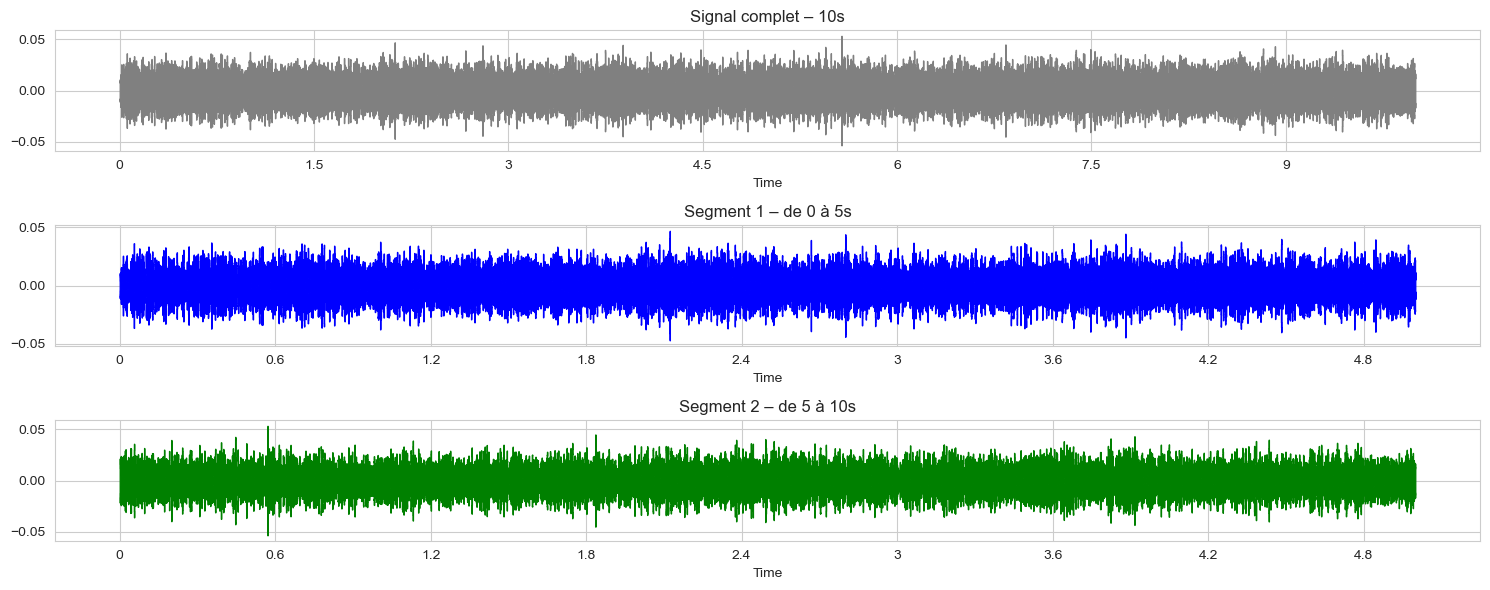

In [3]:
# 📂 Chargement des fichiers segmentés
path_full = output_dir / "segment_full_10s.wav"
path_1 = output_dir / "segment_part1_0_5s.wav"
path_2 = output_dir / "segment_part2_5_10s.wav"

# 🎧 Chargement des signaux
y_full, _ = librosa.load(path_full, sr=sr)
y_1, _ = librosa.load(path_1, sr=sr)
y_2, _ = librosa.load(path_2, sr=sr)

# 📊 Affichage
plt.figure(figsize=(15, 6))

plt.subplot(3, 1, 1)
librosa.display.waveshow(y_full, sr=sr, color='gray')
plt.title("Signal complet – 10s")

plt.subplot(3, 1, 2)
librosa.display.waveshow(y_1, sr=sr, color='blue')
plt.title("Segment 1 – de 0 à 5s")

plt.subplot(3, 1, 3)
librosa.display.waveshow(y_2, sr=sr, color='green')
plt.title("Segment 2 – de 5 à 10s")

plt.tight_layout()
plt.show()


## 🧠 Bloc 3 – Extraction des MFCC et du spectrogramme Log-Mel

Dans ce bloc, nous allons :

- Extraire les MFCC (14 coefficients) + leur taille
- Extraire le spectrogramme Log-Mel (64 bandes) + sa taille
- Visualiser les deux représentations côte à côte

Objectif : comparer la forme et la densité temporelle des deux types de features.


In [4]:
def compute_hop_length_for_target_frames(
    target_frames: int, sr: int = 16000, 
    duration_sec: float = 10.0, n_fft: int = 512
) -> int:
    """
    Compute the hop_length required to obtain a specific number of frames 
    from a given audio duration and sampling rate.

    Args:
        target_frames (int): Desired number of frames in the output feature matrix.
        sr (int): Sampling rate in Hz (default: 16000).
        duration_sec (float): Duration of the signal in seconds (default: 10s).
        n_fft (int): FFT window size (default: 1024).

    Returns:
        int: Calculated hop_length that matches the target frame count.
    """
    total_samples = int(sr * duration_sec)

    if target_frames <= 1:
        raise ValueError("Target frames must be > 1")

    hop_length = (total_samples - n_fft) / (target_frames - 1)
    return int(round(hop_length))


In [27]:
# 📐 Paramètres
n_fft = 512
n_mfcc = 14
n_mels = 64
target_frames = 344  # choisi pour 512 frames sur 10s

In [28]:
# 🎧 Signal complet (10s)
signal, _ = librosa.load(output_dir / "segment_full_10s.wav", sr=sr)

In [29]:
# On veut 512 frames pour un signal 10s à 16kHz
hop_length = compute_hop_length_for_target_frames(
    target_frames=target_frames,
    sr=sr,
    duration_sec=len(signal)/sr,
    n_fft=n_fft
)

print("Calculated hop_length =", hop_length)  # ➜ 463

Calculated hop_length = 465


In [30]:
hop_length = 466

In [31]:
# Extraction des features

# -------- 📈 MFCC (avec Delta et Delta2) --------
mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
delta_mfcc = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
mfcc_stack = np.concatenate([mfcc, delta_mfcc, delta2_mfcc], axis=0)
mfcc_stack = StandardScaler().fit_transform(mfcc_stack.T).T

# -------- 📈 Log-Mel Spectrogram --------
mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
logmel = librosa.power_to_db(mel, ref=np.max)
logmel = MinMaxScaler().fit_transform(logmel.T).T

# -------- Chroma STFT --------
chroma = librosa.feature.chroma_stft(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length)

# -------- Spectral Contrast --------
spec_contrast = librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length)

# -------- Spectral Centroid --------
spec_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length)

# -------- Spectral Rolloff --------
spec_rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length)

# -------- RMS --------
rms = librosa.feature.rms(y=signal, frame_length=n_fft, hop_length=hop_length)


other = np.concatenate([
        chroma,
        spec_contrast,
        spec_centroid,
        spec_rolloff,
        rms
], axis=0)
other = StandardScaler().fit_transform(other.T).T

# ========== Feature Stack ==========
all_features = np.concatenate([mfcc_stack, logmel, other], axis=0)


In [32]:
# 📐 Shapes
print(f"✅ MFCC stack shape: {mfcc_stack.shape}")
print(f"✅ Log-Mel shape: {logmel.shape}")
print(f"✅ Chroma STFT shape: {chroma.shape}")
print(f"✅ Spectral Contrast shape: {spec_contrast.shape}")
print(f"✅ Spectral Centroid shape: {spec_centroid.shape}")
print(f"✅ Spectral Rolloff shape: {spec_rolloff.shape}")
print(f"✅ RMS shape: {rms.shape}")
print(f"✅ All features shape: {all_features.shape}")


✅ MFCC stack shape: (42, 344)
✅ Log-Mel shape: (64, 344)
✅ Chroma STFT shape: (12, 344)
✅ Spectral Contrast shape: (7, 344)
✅ Spectral Centroid shape: (1, 344)
✅ Spectral Rolloff shape: (1, 344)
✅ RMS shape: (1, 344)
✅ All features shape: (128, 344)


Nous utilisons une fonction pour vérifier que le nombre de frames est identique pour chaque feature.  
Cela permet de s'assurer que nos features sont correctement alignées temporellement, ce qui est essentiel pour un traitement ultérieur (ex : concaténation, autoencodeur).

In [33]:
# Fonction pour vérifier l'alignement des frames entre toutes les features
def check_feature_alignment(features_dict):
    """
    Vérifie et affiche le nombre de frames pour chaque feature, et signale si elles sont toutes alignées.
    
    Args:
        features_dict (dict): Dictionnaire de features {nom: np.ndarray}
    """
    frame_counts = {name: feature.shape[1] for name, feature in features_dict.items()}
    print("\n📊 Nombre de frames pour chaque feature :")
    for name, count in frame_counts.items():
        print(f" - {name}: {count} frames")
    
    unique_counts = set(frame_counts.values())
    if len(unique_counts) == 1:
        print(f"\n✅ Toutes les features sont alignées sur {unique_counts.pop()} frames.")
    else:
        print(f"\n⚠️ Désalignement détecté : {unique_counts}")

# Regroupement des features dans un dictionnaire
features_dict = {
    "MFCC_stack": mfcc_stack,
    "LogMel": logmel,
    "Chroma": chroma,
    "SpectralContrast": spec_contrast,
    "SpectralCentroid": spec_centroid,
    "SpectralRolloff": spec_rolloff,
    "RMS": rms,
    "all_features": all_features
}

# Contrôle d'alignement
check_feature_alignment(features_dict)


📊 Nombre de frames pour chaque feature :
 - MFCC_stack: 344 frames
 - LogMel: 344 frames
 - Chroma: 344 frames
 - SpectralContrast: 344 frames
 - SpectralCentroid: 344 frames
 - SpectralRolloff: 344 frames
 - RMS: 344 frames
 - all_features: 344 frames

✅ Toutes les features sont alignées sur 344 frames.


### 📊 Bloc X – Visualisation complète des features audio

Dans ce bloc, nous extrayons les principales features d'un signal audio et affichons :
- MFCC (avec delta et delta2)
- Spectrogramme Log-Mel
- Chroma (stft)
- Spectral Contrast
- Spectral Centroid
- Spectral Rolloff
- RMS

Chaque graphique affiche la représentation temporelle (ou la courbe) ainsi que la shape correspondante.


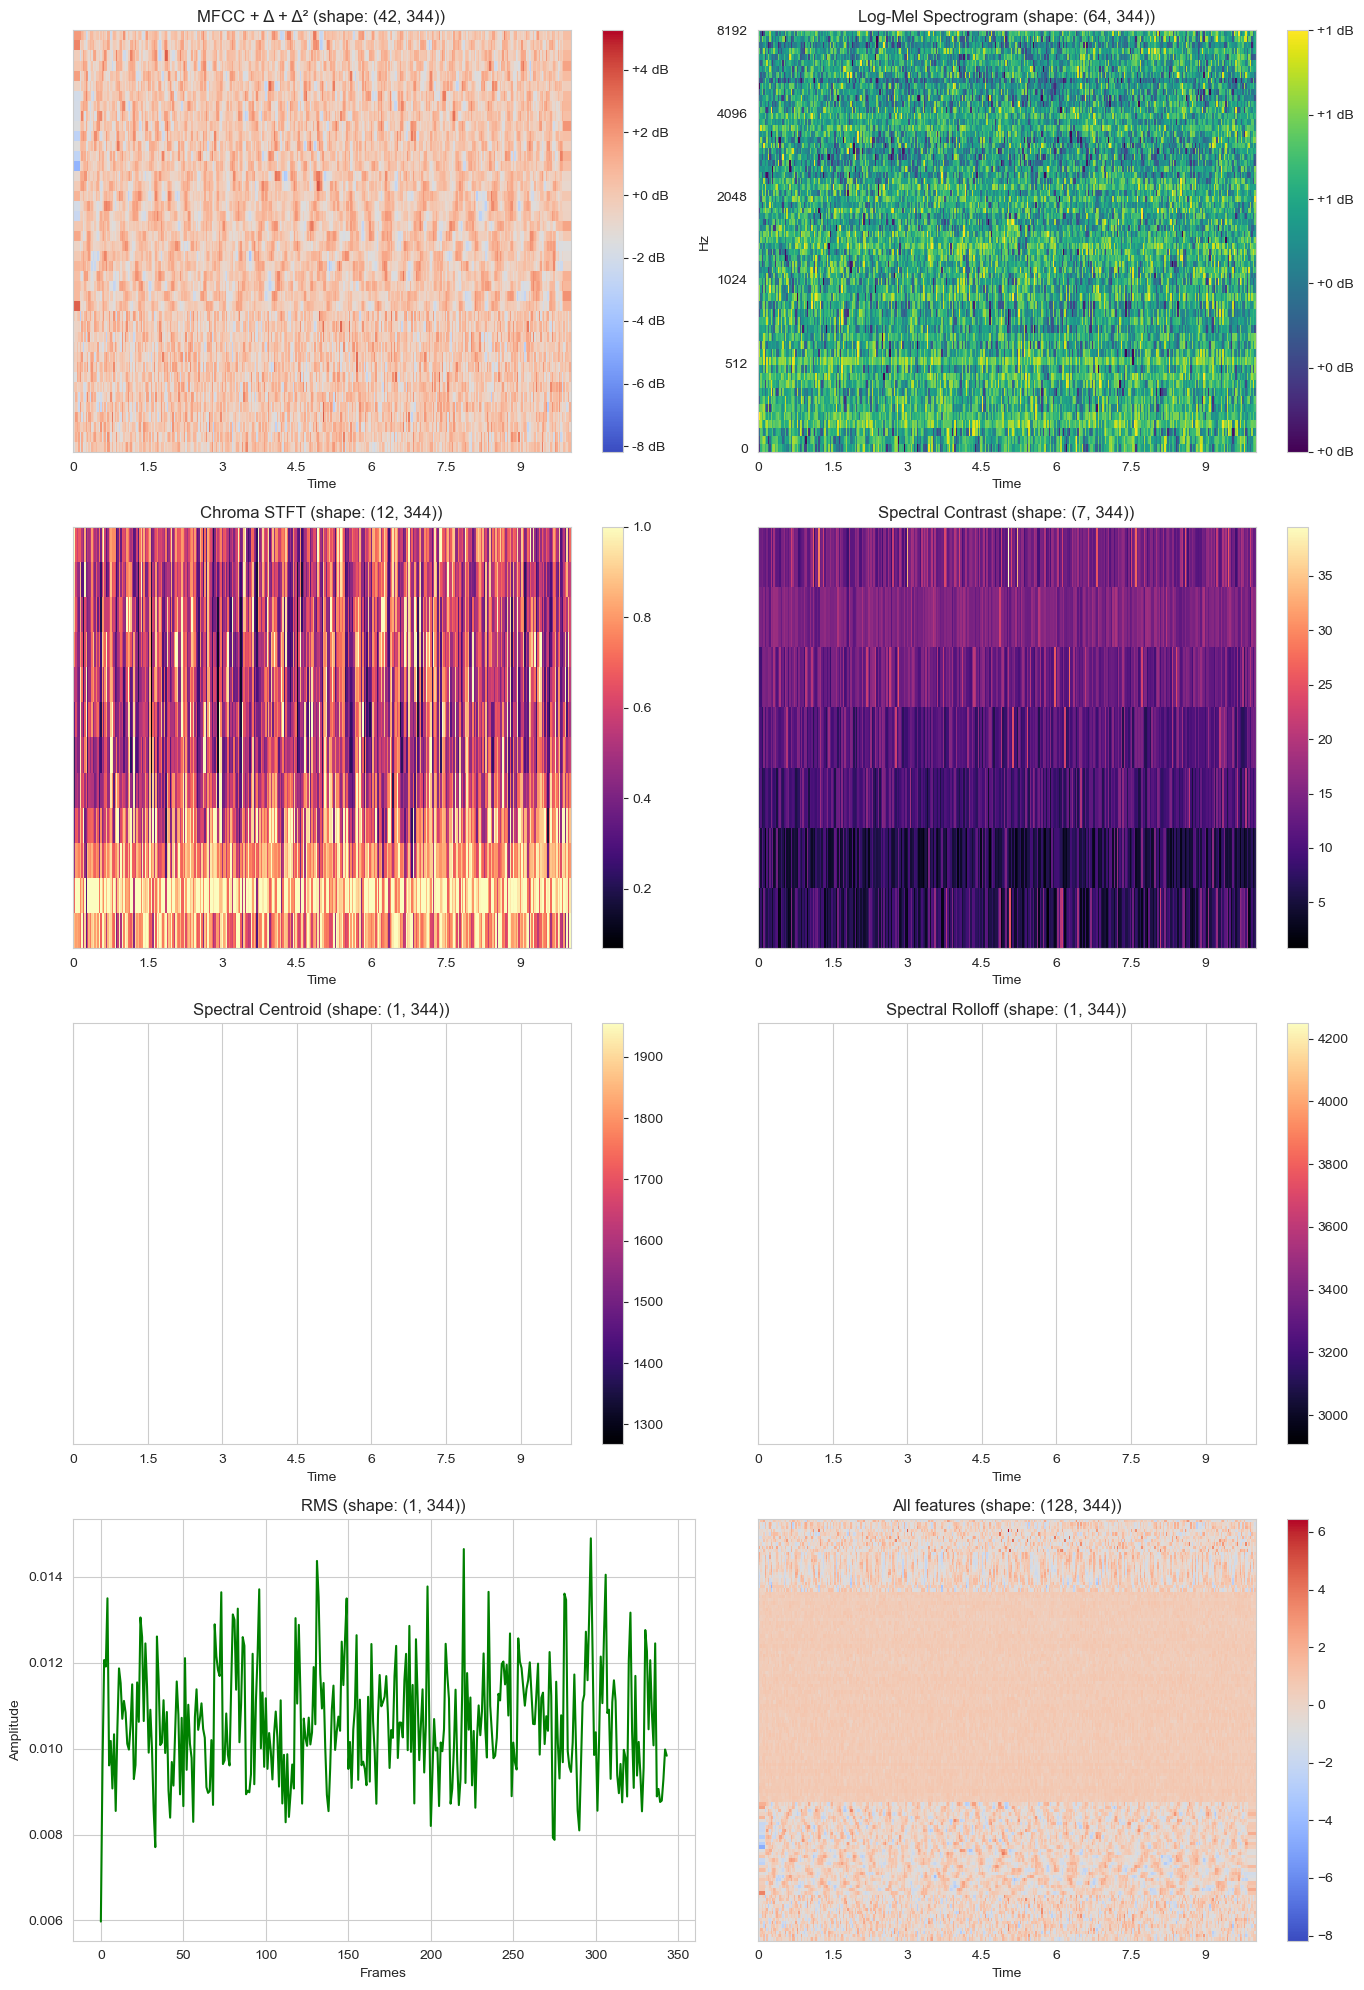

In [34]:
# 🎨 Visualisation
# Affichage dans une grille 4x2
plt.figure(figsize=(14, 20))

# MFCC stack
plt.subplot(4, 2, 1)
librosa.display.specshow(mfcc_stack, sr=sr, hop_length=hop_length, x_axis='time')
plt.title(f"MFCC + Δ + Δ² (shape: {mfcc_stack.shape})")
plt.colorbar(format="%+2.0f dB")

# Log-Mel
plt.subplot(4, 2, 2)
librosa.display.specshow(logmel, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis')
plt.title(f"Log-Mel Spectrogram (shape: {logmel.shape})")
plt.colorbar(format="%+2.0f dB")

# Chroma STFT
plt.subplot(4, 2, 3)
librosa.display.specshow(chroma, sr=sr, hop_length=hop_length, x_axis='time')
plt.title(f"Chroma STFT (shape: {chroma.shape})")
plt.colorbar()

# Spectral Contrast
plt.subplot(4, 2, 4)
librosa.display.specshow(spec_contrast, sr=sr, hop_length=hop_length, x_axis='time')
plt.title(f"Spectral Contrast (shape: {spec_contrast.shape})")
plt.colorbar()

# Spectral Centroid
plt.subplot(4, 2, 5)
librosa.display.specshow(spec_centroid, sr=sr, hop_length=hop_length, x_axis='time')
plt.title(f"Spectral Centroid (shape: {spec_centroid.shape})")
plt.colorbar()

# Spectral Rolloff
plt.subplot(4, 2, 6)
librosa.display.specshow(spec_rolloff, sr=sr, hop_length=hop_length, x_axis='time')
plt.title(f"Spectral Rolloff (shape: {spec_rolloff.shape})")
plt.colorbar()

# RMS
plt.subplot(4, 2, 7)
plt.plot(rms.T, color='green')
plt.title(f"RMS (shape: {rms.shape})")
plt.xlabel("Frames")
plt.ylabel("Amplitude")

# RMS
plt.subplot(4, 2, 8)
librosa.display.specshow(all_features, sr=sr, hop_length=hop_length, x_axis='time')
plt.title(f"All features (shape: {all_features.shape})")
plt.colorbar()

plt.tight_layout()
plt.show()


## 🧪 Bloc 4 – Extraction des MFCC et Log-Mel sur les segments de 5s

On applique les mêmes opérations que précédemment, mais cette fois :

- Sur `segment_part1_0_5s.wav`
- Et `segment_part2_5_10s.wav`

Nous vérifierons la forme des features (doivent être cohérentes avec la version 10s),
et visualiserons les deux types de spectrogrammes pour chaque segment.


In [35]:
# 📁 Chargement des deux segments
segment_paths = [
    output_dir / "segment_part1_0_5s.wav",
    output_dir / "segment_part2_5_10s.wav"
]

hop_length_5 = int(hop_length/2)  # pour 512 frames sur 5s


🔎 Segment 1 : segment_part1_0_5s.wav
MFCC shape : (14, 344)
Log-Mel shape : (64, 344)


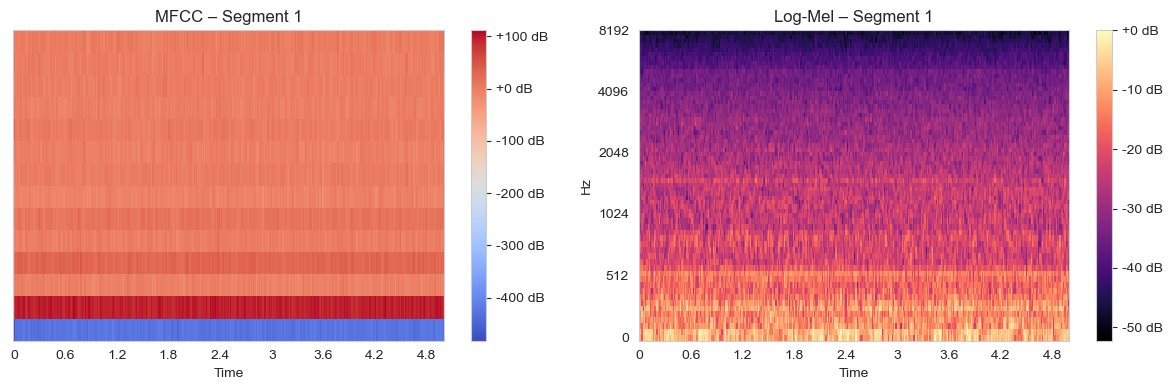


🔎 Segment 2 : segment_part2_5_10s.wav
MFCC shape : (14, 344)
Log-Mel shape : (64, 344)


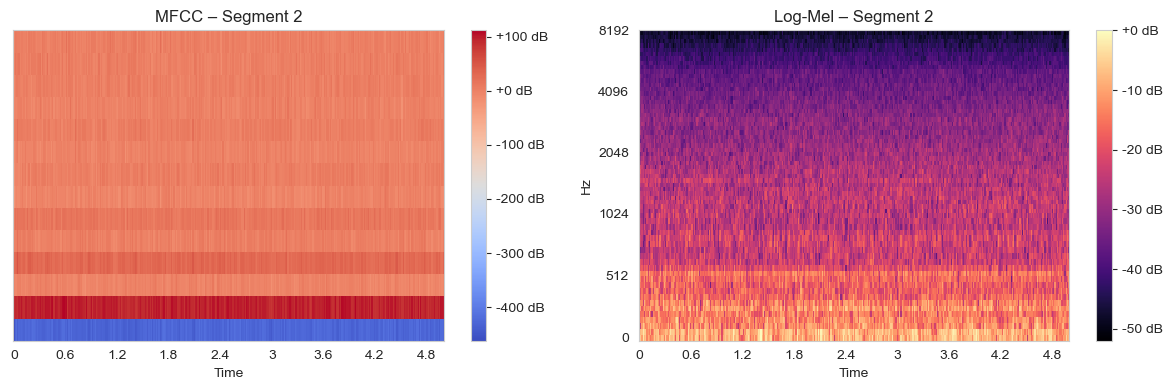

In [36]:
for i, path in enumerate(segment_paths, start=1):
    print(f"\n🔎 Segment {i} : {path.name}")
    
    # 🎧 Chargement
    y_seg, _ = librosa.load(path, sr=sr)
    
    # 📈 MFCC
    mfcc = librosa.feature.mfcc(
        y=y_seg, sr=sr,
        n_mfcc=n_mfcc, n_fft=n_fft,
        hop_length=hop_length_5
    )
    
    # 📈 Log-Mel
    mel = librosa.feature.melspectrogram(
        y=y_seg, sr=sr,
        n_fft=n_fft, hop_length=hop_length_5,
        n_mels=n_mels
    )
    logmel = librosa.power_to_db(mel, ref=np.max)

    # 📐 Shapes
    print(f"MFCC shape : {mfcc.shape}")
    print(f"Log-Mel shape : {logmel.shape}")

    # 🎨 Visualisation
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    librosa.display.specshow(mfcc, sr=sr, hop_length=hop_length_5, x_axis='time')
    plt.title(f"MFCC – Segment {i}")
    plt.colorbar(format="%+2.0f dB")
    
    plt.subplot(1, 2, 2)
    librosa.display.specshow(logmel, sr=sr, hop_length=hop_length_5, x_axis='time', y_axis='mel')
    plt.title(f"Log-Mel – Segment {i}")
    plt.colorbar(format="%+2.0f dB")

    plt.tight_layout()
    plt.show()


## 📊 Bloc 5 – Résumé comparatif des features sur les 3 fichiers

Nous allons :
1. Parcourir chacun des 3 fichiers (10s + 2×5s)
2. Extraire les features MFCC + LogMel
3. Enregistrer la shape (dimensions) de chaque feature
4. Générer un DataFrame récapitulatif
5. Vérifier la cohérence du nombre de frames


In [37]:
# On suppose qu'on a 3 chemins
file_list = [
    output_dir / "segment_full_10s.wav",
    output_dir / "segment_part1_0_5s.wav",
    output_dir / "segment_part2_5_10s.wav"
]

# On va déterminer le hop_length dynamiquement selon la durée
def choose_hop_length_for_duration(file_path, sr=16000, hop_length=hop_length):
    y, _ = librosa.load(file_path, sr=sr)
    duration_sec = len(y) / sr
    # 10s => hop_length = 312, 5s => hop_length = 156 (ou usage direct de fix formula)
    if abs(duration_sec - 10) < 0.5:
        return int(hop_length)  # 10s
    elif abs(duration_sec - 5) < 0.5:
        return int(hop_length/2)  # 5s
    else:
        return None  # inconnu

summary_rows = []

for f in file_list:
    # 1) Charger
    signal, _ = librosa.load(f, sr=sr)
    dur = len(signal) / sr

    # 2) Choix hop_length
    hop_len = choose_hop_length_for_duration(f, sr=sr, hop_length=hop_length)
    if hop_len is None:
        print(f"⚠️ Fichier {f.name} a une durée inédite : {dur:.2f}s -> skip")
        continue

    # 3) Extraction
    mfcc = librosa.feature.mfcc(
        y=signal, sr=sr,
        n_mfcc=n_mfcc, n_fft=n_fft,
        hop_length=hop_len
    )
    mel = librosa.feature.melspectrogram(
        y=signal, sr=sr,
        n_fft=n_fft, hop_length=hop_len,
        n_mels=n_mels
    )
    logmel = librosa.power_to_db(mel, ref=np.max)

    # 4) Stocker shapes
    row = {
        "filename": f.name,
        "duration_sec": f"{dur:.2f}",
        "hop_length": hop_len,
        "mfcc_shape": mfcc.shape,
        "logmel_shape": logmel.shape
    }
    summary_rows.append(row)

# 🏷️ DataFrame récap
df_summary = pd.DataFrame(summary_rows)
df_summary["mfcc_frames"] = df_summary["mfcc_shape"].apply(lambda x: x[1])
df_summary["logmel_frames"] = df_summary["logmel_shape"].apply(lambda x: x[1])

df_summary

# 📊 Affichage final
print("✅ Résumé comparatif :")
display(df_summary)


✅ Résumé comparatif :


,filename,duration_sec,hop_length,mfcc_shape,logmel_shape,mfcc_frames,logmel_frames
0,segment_full_10s.wav,10.00,466,"(14, 344)","(64, 344)",344,344
1,segment_part1_0_5s.wav,5.00,233,"(14, 344)","(64, 344)",344,344
2,segment_part2_5_10s.wav,5.00,233,"(14, 344)","(64, 344)",344,344
